In [1]:
import pandas as pd
import zipfile


zf = zipfile.ZipFile('./berlin-airbnb-data.zip')

file_names = zf.namelist()


calendar_summary = pd.read_csv(zf.open(file_names[0]))

listings = pd.read_csv(zf.open(file_names[1]))

listings_summary = pd.read_csv(zf.open(file_names[2]))

neighbourhoods = pd.read_csv(zf.open(file_names[3]))

reviews = pd.read_csv(zf.open(file_names[4]))

reviews_summary = pd.read_csv(zf.open(file_names[5]))

In [89]:
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df = listings_summary[columns_to_keep].set_index('id')
df.shape

(22552, 22)

In [90]:
df['size'] = df['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df['size'] = df['size'].str.replace("\D", "")

# change datatype of size into float
df['size'] = df['size'].astype(float)

In [91]:
df[['size', 'description']]

,size,description
id,,
2015,75.0,Great location! 30 of 75 sq meters. This wood...
2695,25.0,In the summertime we are spending most of our ...
3176,68.0,This beautiful first floor apartment is situa...
3309,26.0,First of all: I prefer short-notice bookings. ...
7071,20.0,Cozy and large room in the beautiful district ...
...,...,...
29856708,NaN,Charming apartment right in the center of Berl...
29857108,NaN,Die Wohnung liegt in unmittelbarer Nähe zum Vi...
29864272,NaN,Prenzlauer Berg is one of the most creative di...


In [92]:
df['size'].isna().sum()

11794

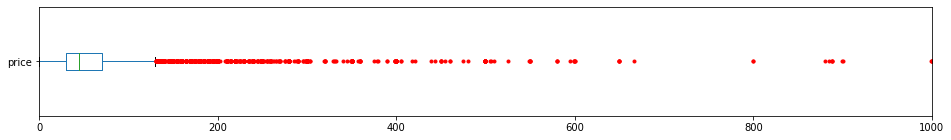

In [93]:
df.cleaning_fee.fillna('$0.00', inplace=True)
df.security_deposit.fillna('$0.00', inplace=True)
df.host_has_profile_pic.fillna('f', inplace=True)

df.price = df.price.str.replace('$', '').str.replace(',', '').astype(float)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df.security_deposit = df.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df.extra_people = df.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [94]:
df.drop(df[ (df.price > 400) | (df.price == 0) ].index, axis=0, inplace=True)

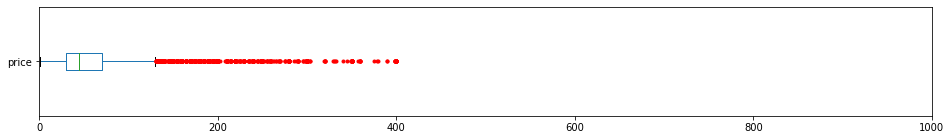

In [95]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [96]:
from geopy.distance import great_circle

def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

df['distance'] = df.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [97]:
df.dropna(subset=['bathrooms', 'bedrooms'], inplace=True)

In [98]:
df.isnull().sum()

space                            8495
description                       202
host_has_profile_pic                0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
bed_type                            0
amenities                           0
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
size                            11721
distance                            0
dtype: int64

In [99]:
sub_df = df[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

y_test = linreg.predict(X_test)

In [100]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']

# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

new_test_data = pd.concat([X_test, y_test], axis=1)

sub_df_new = pd.concat([new_test_data, train_data], axis=0)

df.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

df = pd.concat([sub_df_new, df], axis=1)

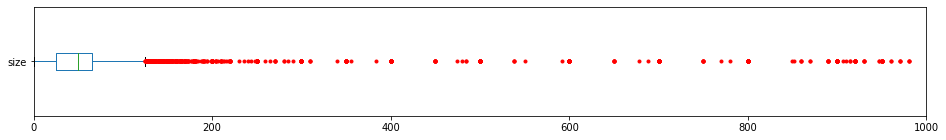

In [101]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [102]:
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [103]:
df.isnull().sum()

accommodates                       0
bathrooms                          0
bedrooms                           0
price                              0
cleaning_fee                       0
security_deposit                   0
extra_people                       0
guests_included                    0
distance                           0
size                               0
space                           8387
description                      202
host_has_profile_pic               0
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
bed_type                           0
amenities                          0
minimum_nights                     0
instant_bookable                   0
is_business_travel_ready           0
cancellation_policy                0
dtype: int64

In [104]:
df.drop(columns=['space', 'description'], inplace = True)

In [105]:
df.isnull().sum()

accommodates                    0
bathrooms                       0
bedrooms                        0
price                           0
cleaning_fee                    0
security_deposit                0
extra_people                    0
guests_included                 0
distance                        0
size                            0
host_has_profile_pic            0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
bed_type                        0
amenities                       0
minimum_nights                  0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
dtype: int64

In [106]:
test_lemma = pd.read_csv('./lemma.csv')

In [107]:
test_lemma

,id,bag_of_words
0,2015,great location 30 75 sq meter wood floor high ...
1,2695,summertime spending weekend little house garde...
2,3176,beautiful floor apartment situate kollwitzplat...
3,3309,prefer short notice booking request 1 2 week a...
4,7071,cozy large room beautiful district prenzlauer ...
...,...,...
22547,29856708,charming apartment right center close main tou...
22548,29857108,wohnung liegt unmittelbarer nähe viktoria luis...
22549,29864272,prenzlauer berg creative district plenty bar r...
22550,29866805,double room private shower wc design artist ro...


In [113]:
df = df.merge(test_lemma.set_index('id'), how = 'left', left_index=True, right_index=True)

In [114]:
df.head().T

,2015,2695,3176,3309,7071
accommodates,3,2,4,2,2
bathrooms,1,1,1,1,1
bedrooms,1,1,1,1,1
price,60,17,90,26,42
cleaning_fee,30,0,50,30,0
security_deposit,200,0,200,250,0
extra_people,28,0,20,18,24
guests_included,1,1,2,1,1
distance,3.53318,5.08557,3.69568,3.75528,4.55042
size,75,25,68,26,20


In [117]:
df.bag_of_words.iloc[0]

'great location 30 75 sq meter wood floor high ceiling typical altbau section apartment consist 1 simple large room small kitchen bathroom + shower apartment mitte close prenzlauer berg mauerpark perfect short visit single couple section close rest big flat wich noticeable share space a+++ location einliegerwohnung extention large apartment separate entrance bathroom kitchen door rest apartment soundproof hide lock barely noticable mirror picture 30 sq meter face quiet courtyard wood floor high ceiling typical altbau apartment consist 1 large room large double bed optionally extra matress 3rd guest small kitchen suitable prepare simple meal bathroom + shower + bathtub course entrance linen '

In [132]:
df_test = df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type', 'bag_of_words', 'amenities'], axis=1).copy()

for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df_test[col] = df_test[col].astype('category')

df_test.head(10)

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,host_has_profile_pic,room_type,bed_type,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.000000,t,Entire home/apt,Real Bed,4,f,f,strict_14_with_grace_period
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.000000,t,Private room,Real Bed,2,f,f,flexible
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677,68.000000,t,Entire home/apt,Real Bed,62,t,f,strict_14_with_grace_period
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285,26.000000,t,Private room,Pull-out Sofa,5,f,f,strict_14_with_grace_period
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423,20.000000,t,Private room,Real Bed,2,f,f,moderate
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,56.697281,t,Entire home/apt,Real Bed,90,f,f,strict_14_with_grace_period
16401,2,1.0,1.0,120.0,0.0,0.0,13.0,1,3.733805,55.000000,t,Private room,Real Bed,30,f,f,strict_14_with_grace_period
16644,5,1.0,1.0,90.0,50.0,500.0,20.0,2,2.105810,80.000000,t,Entire home/apt,Real Bed,60,f,f,strict_14_with_grace_period
17409,2,1.0,1.0,45.0,18.0,0.0,26.0,1,2.982036,25.000000,t,Private room,Real Bed,3,f,f,strict_14_with_grace_period
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,97.756906,t,Entire home/apt,Real Bed,3,f,f,strict_14_with_grace_period


In [136]:
target = df_test[["price"]]

# define our features 
features = df_test.drop(["price"], axis=1)

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

X = enc.fit_transform(features)

In [137]:
X.shape

(21958, 16)

In [142]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [150]:
import xgboost as xgb

booster = xgb.XGBRegressor()

from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2],
              'tree_method': ['gpu_hist']}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=4, verbose=10)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   36.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  4.1min
[Parallel(

[20:01:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'tree_method': 'gpu_hist'}


In [151]:
import joblib
#save model
joblib.dump(booster_grid_search, 'test1_baseline.pkl') 

#load saved model
xgb = joblib.load('test1_baseline.pkl')

[20:01:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [152]:
y_pred = xgb.predict(X_test)

In [153]:
error = mean_squared_error(y_test, y_pred)
error

614.4235512245385

In [154]:
score = r2_score(y_test, y_pred)
score

0.6688743592837318

In [155]:
X_test[0]

array([ 0.26229053, -0.29481738, -0.24359457,  0.59411334,  0.58397699,
        0.59834744, -0.40066681, -0.4858534 ,  0.55786551,  0.05903151,
       -1.03691302,  0.16967069, -0.23666555,  1.49578595,  0.        ,
        0.14909806])

In [168]:
enc.inverse_transform(sc.inverse_transform(X_test[0]).reshape(1,-1))[0]

array([3, 1.0, 1.0, 30.0, 150.0, 15.0, 1, 3.535059047079082,
       57.89136158218128, 't', 'Entire home/apt', 'Real Bed', 3, 't', 'f',
       'moderate'], dtype=object)

In [167]:
joblib.dump(sc, 'standard_scaler1.pkl')
joblib.dump(enc, 'ordinal_necoder1.pkl') 

['ordinal_necoder1.pkl']

In [169]:
sc_test = joblib.load('standard_scaler1.pkl')
enc_test = joblib.load('ordinal_necoder1.pkl')

In [170]:
enc_test.inverse_transform(sc_test.inverse_transform(X_test[0]).reshape(1,-1))[0]

array([3, 1.0, 1.0, 30.0, 150.0, 15.0, 1, 3.535059047079082,
       57.89136158218128, 't', 'Entire home/apt', 'Real Bed', 3, 't', 'f',
       'moderate'], dtype=object)